# Scalable Diffusion Models with Transformer (DiT)

This notebook samples from pre-trained DiT models. DiTs are class-conditional latent diffusion models trained on ImageNet that use transformers in place of U-Nets as the DDPM backbone. DiT outperforms all prior diffusion models on the ImageNet benchmarks.

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

In [ ]:
Making sure having DIT model implenmented first.

In [2]:
import torch

print("CUDA 可用:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU 名称:", torch.cuda.get_device_name(0))


CUDA 可用: True
GPU 名称: NVIDIA GeForce RTX 4080 Laptop GPU


# 1. Setup

We recommend using GPUs (Runtime > Change runtime type > Hardware accelerator > GPU). Run this cell to clone the DiT GitHub repo and setup PyTorch. You only have to run this once.

In [3]:
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")

fatal: destination path 'DiT' already exists and is not an empty directory.


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.5 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.5 MB 2.1 MB/s eta 0:00:01
   -------------------- ------------------- 1.3/2.5 MB 2.4 MB/s eta 0:00:01
   ----------------------------- ---------- 1.8/2.5 MB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 1.0.17
    Uninstalling timm-1.0.17:
      Successfully uninstalled timm-1.0.17


c:\Users\zty15\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download DiT-XL/2 Models

You can choose between a 512x512 model and a 256x256 model. You can swap-out the LDM VAE, too.

In [4]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

c:\Users\zty15\OneDrive\Desktop\DiT\DiT-main\DiT\download.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(local_path, map_location=lambda storage, lo

# 2. Sample from Pre-trained DiT Models

You can customize several sampling options. For the full list of ImageNet classes, [check out this](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

100%|██████████| 250/250 [01:06<00:00,  3.78it/s]


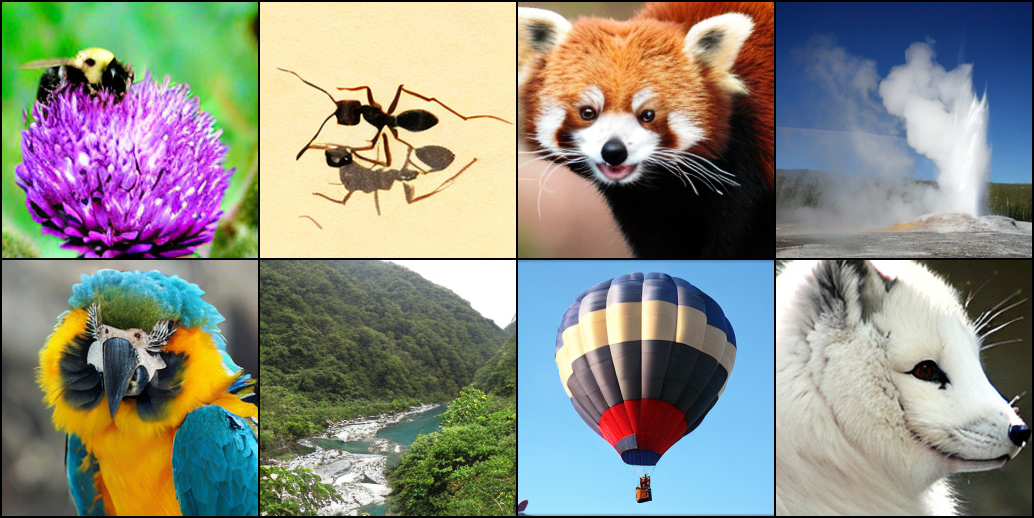

In [7]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 309, 310, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)

In [8]:
# 用模型已有的图片标签生成的

# Set user inputs:
seed = 0
torch.manual_seed(seed)

num_sampling_steps = 250
cfg_scale = 4
class_labels = [309]*4 + [310]*4  # 4张蜜蜂 + 4张熊蜂
samples_per_row = 4

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Run sampling:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)
samples = vae.decode(samples / 0.18215).sample

# Save result:
save_image(samples, "sample.png", nrow=samples_per_row, 
           normalize=True, value_range=(-1, 1))

# Show result (if using notebook):
from PIL import Image
Image.open("sample.png").show()


100%|██████████| 250/250 [01:07<00:00,  3.72it/s]


In [9]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.utils import save_image

# 1. 设置图片文件夹路径（已解压）
image_dir = r"C:\Users\zty15\OneDrive\Desktop\xuebao"  # ← 这0里填你的解压文件夹

# 2. 图像预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 3. 输出文件夹
output_dir = r"C:\Users\zty15\OneDrive\Desktop\genXuebao"
os.makedirs(output_dir, exist_ok=True)

# 4. 读取所有图片
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"🟡 共检测到 {len(image_files)} 张图片，开始生成")

for idx, fname in enumerate(image_files):
    try:
        img_path = os.path.join(image_dir, fname)
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img).unsqueeze(0).to(device)

        # 编码成 latent
        with torch.no_grad():
            latent = vae.encode(img_tensor).latent_dist.sample() * 0.18215

        # 扩展出多个变体
        n_variants = 4
        z = latent.repeat(n_variants, 1, 1, 1)
        z += 0.05 * torch.randn_like(z)

        # 加 class label 和 null label
        z = torch.cat([z, z], 0)
        y = torch.tensor([289]*n_variants + [1000]*n_variants, device=device)
        model_kwargs = dict(y=y, cfg_scale=4)

        # 采样
        with torch.no_grad():
            samples = diffusion.p_sample_loop(
                model.forward_with_cfg,
                z.shape,
                z,
                model_kwargs=model_kwargs,
                device=device,
                progress=False
            )

        # 解码
        samples, _ = samples.chunk(2)
        decoded = vae.decode(samples / 0.18215).sample

        # 保存
        out_file = os.path.join(output_dir, f"bee_{idx:03d}.png")
        save_image(decoded, out_file, nrow=2, normalize=True, value_range=(-1, 1))
        print(f"✅ {fname} → {out_file}")

    except Exception as e:
        print(f"❌ 跳过 {fname}，出错: {e}")

print("🎉 批处理完成，生成图像保存在:", output_dir)


🟡 共检测到 101 张图片，开始生成
✅ resized_256x256.jpg → C:\Users\zty15\OneDrive\Desktop\genXuebao\bee_000.png
✅ snow_leopard_000.jpg → C:\Users\zty15\OneDrive\Desktop\genXuebao\bee_001.png


KeyboardInterrupt: 